In [1]:
import random
from pathlib import Path

import torch
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import ConcatDataset

from load_data_functions import ImageFolderCustom, create_dataloaders, select_subset
from engine import load_enet_best, get_loss_optimizer, create_writer, train, pretty_json, plot_loss_curves, pred_and_plot_n_images

In [2]:
# get current hyperparameter setup
batch_size = 256
loss_fn_str = "MSE"
learning_rate = 0.0009
optimizer_str = "Adam"
num_epochs = 13
train_percentage = 1.0
dropout = 0.261807
augmentation = True

In [3]:
# other variables relevant for training
split_path = Path("data/train_test_split")
test_path = split_path / "test"
train_path = split_path / "train"
img_size = 224
model_name = "pretrained_enet"

In [4]:
# setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
model = load_enet_best(device, dropout=dropout)
summary(model=model,
        input_size=(batch_size, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Created a new pretrained EfficientNet-B0 model.


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [256, 3, 224, 224]   [256, 1]             --                   Partial
├─Conv2dSame (conv_stem)                           [256, 3, 224, 224]   [256, 32, 112, 112]  (864)                False
├─BatchNormAct2d (bn1)                             [256, 32, 112, 112]  [256, 32, 112, 112]  64                   False
│    └─Identity (drop)                             [256, 32, 112, 112]  [256, 32, 112, 112]  --                   --
│    └─SiLU (act)                                  [256, 32, 112, 112]  [256, 32, 112, 112]  --                   --
├─Sequential (blocks)                              [256, 32, 112, 112]  [256, 320, 7, 7]     --                   False
│    └─Sequential (0)                              [256, 32, 112, 112]  [256, 16, 112, 112]  --                   False
│    │    └─DepthwiseSeparableConv (0)  

In [6]:
# get loss function and optimizer
loss_fn, optimizer = get_loss_optimizer(loss_fn_str, optimizer_str, model, learning_rate)

In [7]:
# define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

augment_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),  # resize the images
    # randomly add Gaussian blur
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.7),
    # randomly perform a horizontal flip
    transforms.RandomHorizontalFlip(p=0.7),
    # turn the images into a torch.Tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
# load training and test data
test_data = ImageFolderCustom(targ_dir=test_path, transform=data_transforms)
train_data = ImageFolderCustom(targ_dir=train_path, transform=data_transforms)
if augmentation:
    augmented = ImageFolderCustom(targ_dir=train_path, transform=augment_transform)
    train_data = ConcatDataset([train_data, augmented])

if train_percentage < 1.0:
    train_data = select_subset(train_data, train_percentage)

print(f"Size of the training set: {len(train_data)}")
print(f"Size of the test set: {len(test_data)}")
train_loader, test_loader = create_dataloaders(train_data, test_data, device, batch_size)

Size of the training set: 49436
Size of the test set: 4424


In [9]:
# create a writer to track training results
writer = create_writer(f"final_training", model_name)

[INFO] Created SummaryWriter, saving to: runs\final_training\pretrained_enet\2024-05-31_07-46-58...


In [10]:
# track hyperparameters and other important information
info = {
    "model_name": model_name,
    "batch_size": batch_size,
    "loss_fn_str": loss_fn_str,
    "learning_rate": learning_rate,
    "augmentation": False,
    "split_path": str(split_path),
    "train_path": str(train_path),
    "test_path": str(test_path),
    "img_size": img_size,
    "num_epochs": num_epochs,
    "optimizer_str": optimizer_str,
    "percentage": train_percentage
}

writer.add_text("Miscellaneous", pretty_json(info))

In [11]:
# train the model and track performance
model.to(device)
performance = train(num_epochs=num_epochs,
                    model=model,
                    train_loader=train_loader,
                    val_loader=test_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    device=device,
                    writer=writer,
                    early_stopping=False)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0513 | train_ccc: 0.6071 | train_pcc: 0.6284 | val_loss: 0.0488 | val_ccc: 0.3406 | val_pcc: 0.3943
Epoch: 2 | train_loss: 0.0394 | train_ccc: 0.7021 | train_pcc: 0.7215 | val_loss: 0.0560 | val_ccc: 0.3701 | val_pcc: 0.4114
Epoch: 3 | train_loss: 0.0371 | train_ccc: 0.7231 | train_pcc: 0.7396 | val_loss: 0.0492 | val_ccc: 0.3140 | val_pcc: 0.3615
Epoch: 4 | train_loss: 0.0352 | train_ccc: 0.7337 | train_pcc: 0.7505 | val_loss: 0.0466 | val_ccc: 0.3597 | val_pcc: 0.4084
Epoch: 5 | train_loss: 0.0356 | train_ccc: 0.7342 | train_pcc: 0.7521 | val_loss: 0.0543 | val_ccc: 0.3628 | val_pcc: 0.4125
Epoch: 6 | train_loss: 0.0360 | train_ccc: 0.7348 | train_pcc: 0.7508 | val_loss: 0.0486 | val_ccc: 0.3274 | val_pcc: 0.3716
Epoch: 7 | train_loss: 0.0353 | train_ccc: 0.7378 | train_pcc: 0.7533 | val_loss: 0.0624 | val_ccc: 0.2180 | val_pcc: 0.2668
Epoch: 8 | train_loss: 0.0347 | train_ccc: 0.7402 | train_pcc: 0.7568 | val_loss: 0.0482 | val_ccc: 0.3640 | val_pcc: 0.4156


In [12]:
# save the trained model
torch.save(model.state_dict(), "pretrained_models/final_enet.pth")

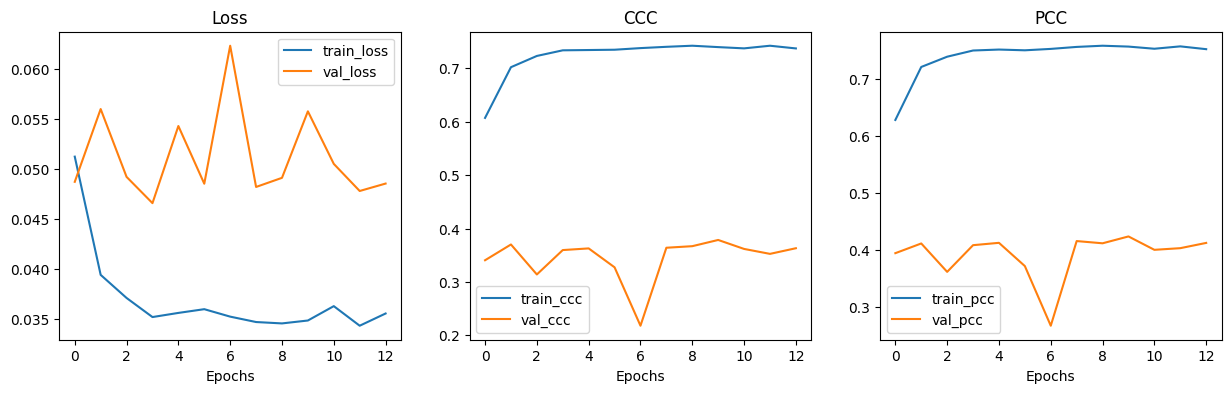

In [13]:
# plot loss curves
plot_loss_curves(performance)

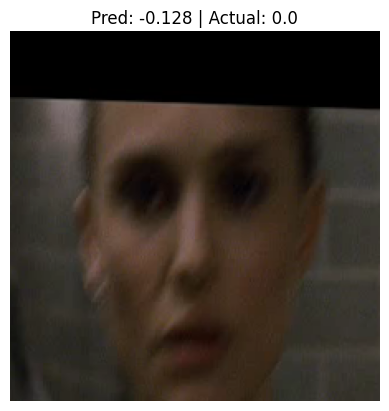

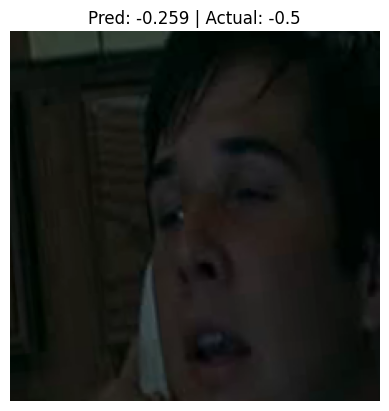

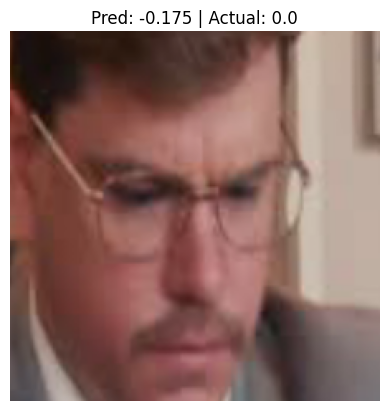

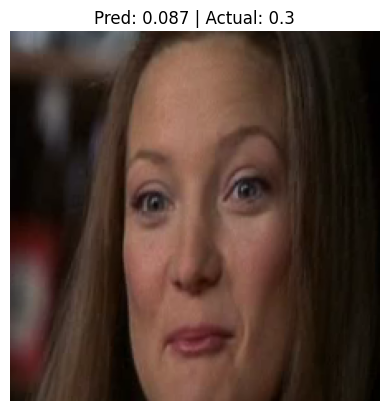

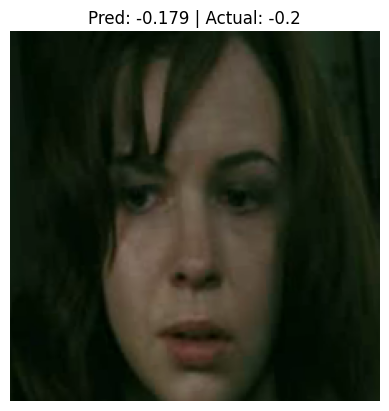

In [14]:
# make predictions
pred_and_plot_n_images(model=model, 
                       val_path = test_path, 
                       num_images_to_plot=5, 
                       image_size=(img_size, img_size), 
                       transform=data_transforms,
                       device=device)